# The Power of Bayesian Inference estimated using PyMC3 
## If you've steered clear of Bayesian regression because of its complexity, this article looks at how to apply simple MCMC Bayesian Inference to linear data with outliers in Python, using linear regression and Gaussian random walk priors, testing assumptions on observation errors from Normal vs Student-T prior distributions and comparing against ordinary least squares.

![Bayesian Inference](http://www.appliedmachinelearning.ai/assets/images/randomwalk_regression.jpg "Bayesian Inference with PyMC3")

### Overview
The beauty of Bayesian methods is their ability to generate probability estimates of the quality of derived models based on *a priori* expectations of the behaviour of the model parameters. Rather than a single point-solution, we obtain a distribution of solutions each with an assigned probability. *A priori* expectations of the data behaviour are formulated into a set of *Priors*, probability distributions over the model parameters.

Choosing these priors injects into the model certain presumptions about the behaviour of the data. Whilst this may seem an unjustified biasing of the machine learning process, it in fact makes explicit assumptions which in other methods are hidden.

The following scenario is based on [Thomas Wiecki](https://docs.pymc.io/notebooks/GLM-robust.html)'s excellent article "GLM: Robust Linear Regression" [1] and is an exploration of the Python library PyMC3 [2] as a means to model data using Markov chain Monte Carlo (MCMC) methods in Python, with some discussion of the predictive power of the derived Bayesian models. Different priors are considered, including Normal, Student-T, Gamma and Gaussian Random Walk, with a view to model the sample data both using generalized linear models (GLM) and by taking a non-parametric approach, estimating observed data directly from the imputed priors.

### Sample Data
The sample data here is generated as a simple linear model with given intercept and slope, with an additional random Gaussian noise term added to each observation. To make the task interesting, a small number of outliers are added to the distribution which have no algebraic relationship to the true linear model. Our objective is to model the observed linear model as closely as possible with the greatest possible robustness to disruption by the outliers and the observation error terms. As an aside, this statement itself presupposes the outcome we expect: we have made a value judgement on the notions of 'outlier' and 'error term', as against what we believe are the *true* underlying linear data values. 

Once we discover a linear model, there are further mechanisms by which outliers could be identified and removed from the data set, which can further improve the linear model [3]. We do not consider these approaches in this case. They impose further presumptions on the shape of the underlying data which we prefer not to make. In general, the less we arbitrarily constrain a model the more likely it is to handle out of sample data. If we model well, our predictions will come with an associated probability, which should protect us from unwarranted assertions as to future trends in the data.

### Normal vs Student-T priors
As part of this analysis we compare models based on Normal versus Student-T observational error priors. Thomas Wiecki in his article shows that a Student-T distribution is better than the Normal distribution at handling outliers in linear regression, as the Student-T distribution has longer tails than the Gaussian. This conveys the notion that an outlier is not to be considered wholly unexpected. In other scenarios where outliers might be very informative and unexpected, we would not want to follow this approach but rather use an outlier detection mechanism as mentioned above.

Thomas Wiecki suggests as an "exercise for the reader" that in estimating a Bayesian linear model, a prior be placed on the degrees of freedom parameter in the Student-T distribution of observation errors. This parameter, termed nu, describes how much mass should be put into the distribution's tails. We have followed this suggestion and discuss the results below.

### Roadmap
The following article covers:
- Setup and generate sample linear data with outliers and render with ordinary least squares (OLS) model
- Compute Bayesian liner regression model with PyMC3 using Normal and Student-T error distributions
- Refinement of the Student-T model by including prior on degrees of freedom parameter
    1. Model Degrees of Freedom in Student-T
    2. Plot prior probability distributions
    3. Visualize credibility intervals on the sampled conditioned priors
- Investigate posterior inference predictive power
- Non-parametric Models using Gaussian Random Walk prior
- Plotting Posterior Samples
- Conclusion

### Import libraries and set defaults

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano
import seaborn

# True line definition
true_intercept = 1
true_slope = 3
observables = 50

# Outliers
outliers_x = [4, 6, 7]
outliers_y = [9.5, 6, 14.8]

# Credibility Intervals
quartiles = [2.5, 25, 50, 75, 97.5]
no_quartiles = len(quartiles)

# Plot theme
seaborn.set_style("darkgrid")
pal_1 = seaborn.light_palette('green')
pal_2 = seaborn.light_palette('blue')

# Plot scaling
fig_size_x, fig_size_y = 16, 6
y_min_compact, y_max_compact = -0.04, 16
y_min_spread, y_max_spread = -10.04, 24

# Sampling
samples_glm = 1500
tune_glm = 500

samples_predictive = 2000
tune_predictive = 1500

## Generate true linear model
We can easily generate a simulated dataset of observations of the form $y = ax + b + epsilon$, with the noise term epsilon being term drawn from a normal distribution. 

### Setup
In our case we are:

1. creating observation values in the range x from 0 to 1.5, based on the simulated 'true' linear model, 
2. adding test outliers
3. extending the x axis from 1.5 to 3.0 so we can test the predictive power of our models into this region. In this region set observed values to 0, or NaN. 

In the predictive region, from 1.5 to 3, we have used numpy $MaskedArray$ function in order to indicate to PyMC3 that we have unknown observational data in this region, while maintaining the array shape required by the Markov Chains (ref [15]). These unknown observations effectively become parameters to be imputed by the optimisation process.

In [2]:
def add_outliers(y, outliers_x, outliers_y):
    y_observed = y
    for i in range(len(outliers_x)):
        y_observed[outliers_x[i]] = outliers_y[i]

    y_predicted = np.append(y_observed, [0] * observables)
    y_predicted = np.ma.MaskedArray(y_predicted,np.arange(y_predicted.size)>=observables)
    return y_observed, y_predicted
    
x_observed = np.linspace(0, 1.5, observables)
x_delta = np.linspace(1.5, 3.0, observables)
x_predicted = np.append(x_observed, x_delta)

predicted_line = true_intercept + true_slope * x_predicted

y = true_intercept + true_slope * x_observed + np.random.default_rng(seed=123).normal(scale=0.5, size=observables) # Add noise

y_observed, y_predicted = add_outliers(y, outliers_x, outliers_y)

## Plot simulated data with true regression line and ordinary least squares (OLS) linear regression
As a benchmark it is useful to visualize the simulated data, along with the true regression line and an ordinary least squares regression based on minimising the squared distance of the points from a target line (RMSE). The Seaborn library allows us to draw this plot directly [4], and we can also invoke a 'robust' flag which calculates the regression line while de-weighting outliers.

The *true*, *RMSE* and *Robust RMSE* regression lines and sample observation points are drawn below:

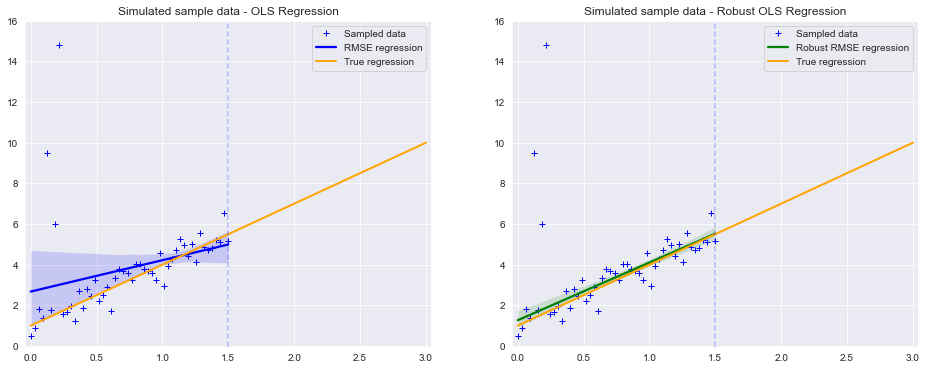

In [3]:
def plot_sample_data(ax, y_min, y_max):
    ax.set_xlim(-0.04, 3.04)
    ax.set_ylim(y_min, y_max)
    plt.plot(x_predicted, y_predicted, '+', label='Sampled data', c=pal_2[5])

def plot_true_regression_line(title, loc):
    plt.plot(x_predicted, predicted_line, lw=2., label = 'True regression', c='orange')
    plt.axvline(x=x_predicted[observables],linestyle='--', c='b',alpha=0.25)
    plt.title(title)
    plt.legend(loc=loc)
        
data = dict(x=x_observed, y=y_observed)
fig = plt.figure(figsize=(fig_size_x, fig_size_y))
ax1 = fig.add_subplot(121)
plot_sample_data(ax1, y_min_compact, y_max_compact)
seaborn.regplot(x="x", y="y", data=data, marker="+", color="b", scatter=False, label="RMSE regression")
plot_true_regression_line('Simulated sample data - OLS Regression', 'best')

ax2 = fig.add_subplot(122)
plot_sample_data(ax2, y_min_compact, y_max_compact)
seaborn.regplot(x="x", y="y", data=data, marker="+", color="g", robust=True, scatter=False, label="Robust RMSE regression")
plot_true_regression_line('Simulated sample data - Robust OLS Regression', 'best')

For many purposes this visualisation is good enough. However the most obvious omission in these models is that we have only modelled in the region of the sample data and other than a simple extrapolation of the regression line, we have no indication of the reliability of predicting beyond the observed data. 

It has been argued that this is where machine learning diverges from statistics. "Prediction vs. Explanation ... Machine learning models are designed to make the most accurate predictions possible. Statistical models are designed for inference about the relationships between variables." [5]. The relative merits of Bayesian Regression vs Linear Regression are well discussed elsewhere (For example [6]).

### Bayesian Regression with PyMC3
Following the example of Thomas Weicki (*op. cit.*) we can easily create linear regression models in PyMC3, creating the linear model from the formula $y(x) = $ ***'y ~ x'*** based on the observed data using ***pymc3.glm.GLM.from_formula()*** method.

In order to test the notion of **Robust** regression, we will create two models, one based on a normal distribution of observational data errors and a second based on the Student-T distribution which we expect to be less influenced by the outliers.

The ***pymc3.sample()*** method will then sample conditioned priors for us automatically. In the case of the Normal model, the default priors will be for intercept, slope and standard deviation in epsilon. In the case of the Student-T model, which we create by setting the formula family as below, these will be for intercept, slope and lam (scale parameter [7]).

In [4]:
data = dict(x=x_observed, y=y_observed)
with pm.Model() as n_model:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace_normal_glm = pm.sample(samples_glm, tune=tune_glm, random_seed=123, cores=2, chains=2)
    
with pm.Model() as t_model:
    pm.glm.GLM.from_formula('y ~ x', data, family = pm.glm.families.StudentT())
    trace_studentT_glm = pm.sample(samples_glm, tune=tune_glm, random_seed=123, cores=2, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 629.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 579.45draws/s]


The effect of running these two models is to create $trace$ objects containing a family of sampled parameter sets for each model over all chains, with the parameters conditioned from the priors based on the observational data.

PyMC3 has a convenient helper function, ***pymc3.plot_posterior_predictive_glm()*** to sample and visualize regression lines drawn from the conditioned parameter distributions.

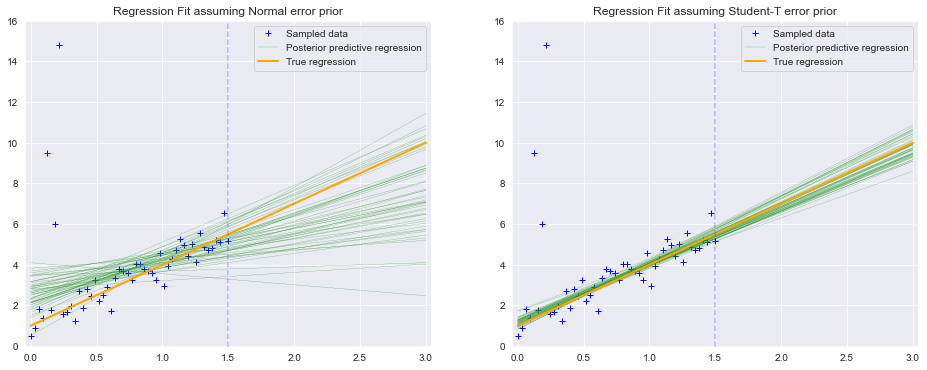

In [5]:
fig = plt.figure(figsize=(fig_size_x, fig_size_y))
ax1 = fig.add_subplot(121)
plot_sample_data(ax1, y_min_compact, y_max_compact)
pm.plot_posterior_predictive_glm(trace_normal_glm, eval=x_predicted, samples=50, label='Posterior predictive regression', c=pal_1[4])
plot_true_regression_line('Regression Fit assuming Normal error prior', 'best')

ax2 = fig.add_subplot(122)
plot_sample_data(ax2, y_min_compact, y_max_compact)
pm.plot_posterior_predictive_glm(trace_studentT_glm, eval=x_predicted, samples=50, label='Posterior predictive regression', c=pal_1[4])
plot_true_regression_line('Regression Fit assuming Student-T error prior', 'best')

As can be seen, the samples drawn from the model using the Student-T prior appear much closer to the true regression line that those from the Normal prior.

### Comparison of Normal vs Student-T error distributions
A summary of the parameter distributions can be obtained from ***pymc3.summary(trace)*** and we can see below that the intercept from the Student-T error prior is **1.155**, with slope **2.879**, which is much closer to the expected value of **(1, 3)** for our true regression line than from the Normal error prior, which gives an intercept of **2.620** with slope **1.608**.

In [6]:
pm.summary(trace_normal_glm)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept  2.620  0.656   1.429    3.862      0.018    0.013    1303.0   
x          1.608  0.746   0.267    2.989      0.021    0.015    1287.0   
sd         2.264  0.233   1.882    2.737      0.006    0.004    1564.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept  1303.0    1317.0    1296.0    1.0  
x          1235.0    1303.0    1402.0    1.0  
sd         1564.0    1565.0    1743.0    1.0

In [7]:
pm.summary(trace_studentT_glm)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept  1.155  0.177   0.833    1.497      0.005    0.004    1056.0   
x          2.879  0.199   2.512    3.242      0.006    0.004    1045.0   
lam        8.368  3.249   3.543   14.268      0.095    0.074    1158.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept  1028.0    1072.0    1300.0    1.0  
x          1045.0    1043.0    1137.0    1.0  
lam         970.0    1396.0     947.0    1.0

## Refinement of Student-T error distribution
Can we do any better? It is clear from the plots above that we have achieved our objective of improving the regression by using a Student-T prior rather than the Normal prior on the errors.

It would be nice to go further with this as Wiecki suggested:

1. Model Degrees of Freedom in Student-T
2. Plot prior probability distributions
3. Visualize credibility intervals on the sampled conditioned priors

### 1. Model Degrees of Freedom in Student-T
First we need to construct two new models, as below, where as well as parameterizing the intercept, $b_0$, and the slope, $a_0$, we are also creating priors on $sigma_0$ in the Normal model and $nu_0$, the degrees of freedom, in the Student_T model. The distribution for the Normal model's standard deviation prior is a HalfCauchy, which is a positive domain Student-T with one degree of freedom. The Student-T model's degrees of freedom parameter prior is modelled as a Gamma function. This is as recommended by Andrew Gelman who suggests after Juárez and Steel (2010) proposed nu ~ gamma(alpha=2, beta=0.1) [7]. In the previous run we obtained a Student-T lam value (the scale factor) of 8.368 and so have retained this in the following model, while allowing $nu_0$ to be optimised.

Note that to make our model more evident we are now explicitly defining the model $ mu_0 = a_0 * x + b_0$ as the basis of the sample likelihood distribution $y_0$, rather than using GLM.from_formula() (ref [14]).

Here we define and run these two models, returning

- The model trace, which has the marginalised priors having taken into account the observational data
- The posterior predicted values of the observations, $y_0$ which is the sample likelihood marginalized over the parameters:

In [8]:
def create_normal_glm_model(samples, tune, x, y):
    with pm.Model() as model_normal:
        a_0 = pm.Normal('a_0', mu=1, sigma=10)
        b_0 = pm.Normal('b_0', mu=1, sigma=10)
        mu_0 = a_0 * x + b_0
        sigma_0 = pm.HalfCauchy('sigma_0', beta=10)

        y_0 = pm.Normal('y_0', mu=mu_0, sigma=sigma_0, observed=y)
        trace_normal = pm.sample(samples, tune=tune, random_seed=123, cores=2, chains=2)

        return trace_normal, pm.sample_posterior_predictive(trace_normal, random_seed=123)['y_0']

def create_studentT_glm_model(samples, tune, x, y):
    with pm.Model() as model_studentT:
        a_0 = pm.Normal('a_0', mu=1, sigma=10)
        b_0 = pm.Normal('b_0', mu=1, sigma=10)
        mu_0 = a_0 * x + b_0
        nu_0 = pm.Gamma('nu_0', alpha=2, beta=0.1)

        y_0 = pm.StudentT('y_0', mu=mu_0, lam=8.368, nu=nu_0, observed=y)
        trace_studentT = pm.sample(samples, tune=tune, random_seed=123, cores=2, chains=2)
    
        return trace_studentT, pm.sample_posterior_predictive(trace_studentT, random_seed=123)['y_0']

trace_normal_glm_explicit, y_posterior_normal_glm = create_normal_glm_model(samples_glm, tune_glm, x_observed, y_observed)
trace_studentT_glm_explicit, y_posterior_studentT_glm = create_studentT_glm_model(samples_glm, tune_glm, x_observed, y_observed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_0, b_0, a_0]
100%|██████████| 3000/3000 [00:02<00:00, 1144.11it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_0, b_0, a_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 584.48draws/s]
The acceptance probability does not match the target. It is 0.8822687875216361, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 3000/3000 [00:01<00:00, 1515.86it/s]


#### Enhanced Results after refining $nu_0$

In [9]:
pm.summary(trace_normal_glm_explicit)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a_0      1.538  0.752   0.075    2.882      0.023    0.016    1067.0  1067.0   
b_0      2.690  0.660   1.437    3.927      0.020    0.014    1124.0  1117.0   
sigma_0  2.271  0.245   1.834    2.728      0.006    0.005    1504.0  1470.0   

         ess_bulk  ess_tail  r_hat  
a_0        1062.0    1299.0    1.0  
b_0        1119.0    1119.0    1.0  
sigma_0    1564.0    1688.0    1.0

In [10]:
pm.summary(trace_studentT_glm_explicit)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a_0   2.906  0.190   2.550    3.272      0.006    0.004    1114.0  1111.0   
b_0   1.144  0.168   0.824    1.475      0.005    0.004    1134.0  1134.0   
nu_0  1.520  0.369   0.909    2.216      0.009    0.006    1771.0  1707.0   

      ess_bulk  ess_tail  r_hat  
a_0     1118.0    1186.0    1.0  
b_0     1131.0    1166.0    1.0  
nu_0    1808.0    1524.0    1.0

From ***pymc3.summary(trace)*** above we can see that the intercept from the Student-T error distribution is now **1.144**, with slope **2.906** against the previous result of **1.155**, with slope **2.879**, so we have moved even closer to the expected value of **(1, 3)**. The results from the new Normal error model have not changed which is as expected.

It is worth noting that we are attempting to fit a linear model to data that is not purely linear, since it has outliers which do not fit the linear model. The only way to obtain a true linear outcome would be to locate and remove the outliers using methods already mentioned. It would be surprising if we found a solution of exactly **(1, 3)** while the outliers are still part of the input data.

#### 2. Plot prior probability distributions
It is instructive to view the shapes of the Normal against the Student-T probability distribution, plugging in the actual mean conditioned parameters (ref https://docs.pymc.io/api/distributions/continuous.html).

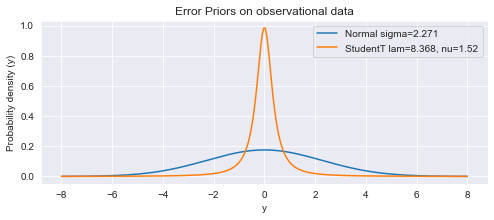

In [11]:
def plot_distributions(sigma, nu, lam):
    normal_dist = pm.Normal.dist(mu=0, sigma=sigma)
    t_dist = pm.StudentT.dist(mu=0, nu=nu, lam=lam)
    x_eval = np.linspace(-8, 8, 300)
    fig = plt.figure(figsize=(8, 3))
    plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label=f'Normal sigma={sigma}')
    plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label=f'StudentT lam={lam}, nu={nu}')
    plt.xlabel('y')
    plt.ylabel('Probability density (y)')
    plt.title('Error Priors on observational data')
    plt.legend()

plot_distributions(2.271, 1.520, 8.368)

It can be seen that the Student-T distribution does have greater reach into the tails, which indicates as a prior that outlying values are not to be considered as so exceptional as would be in the Normal case, so they have less information content in terms of disrupting the posterior likelihood.

The plots suggest that the Normal standard deviation has had to widen in order to accommodate the outliers, whereas the Student-T distribution has been able to retain a tight central body which covers the true sample points, while the longer tail can take in the existence of outliers. This is born out in the plots for the credibility intervals in the following which show that not only is the regression line a much better fit when using the Student-T distribution, the 50% and 95% credibility intervals are much closer to the median line.

#### 3. Visualize credibility intervals on the sampled conditioned priors
Having fitted the models, we want to visualize the mean, 50% and 95% credibility intervals (CI) [9] of the sampled conditioned priors. In PyMC3 all this information is held in the trace object which has calculated values of all the priors for all the samples across all the Markov chains. In the case of the linear model, we have intercept and slope for every sample which allows us to calculate expected $y$ at every point on the $x$ axis and we then can use ***numpy.percentile()*** to aggregate these samples into credibility interval ranges at every point $x$.

In [12]:
def calculate_regression_line(trace):
    a0 = trace['a_0']
    b0 = trace['b_0']

    y_pred = np.array([])
    for x_i in x_predicted:
       y_quartiles = np.percentile(a0 * x_i + b0, quartiles)
       y_pred = np.append(y_pred, y_quartiles)
    return np.transpose(y_pred.reshape(len(x_predicted), no_quartiles))

Once we have the array of credible intervals at each point x, we can easily plot the regression line, with credible regions within which we expect our optimised regression line to be valid.

These plot helper functions are used to simplify the plotting:

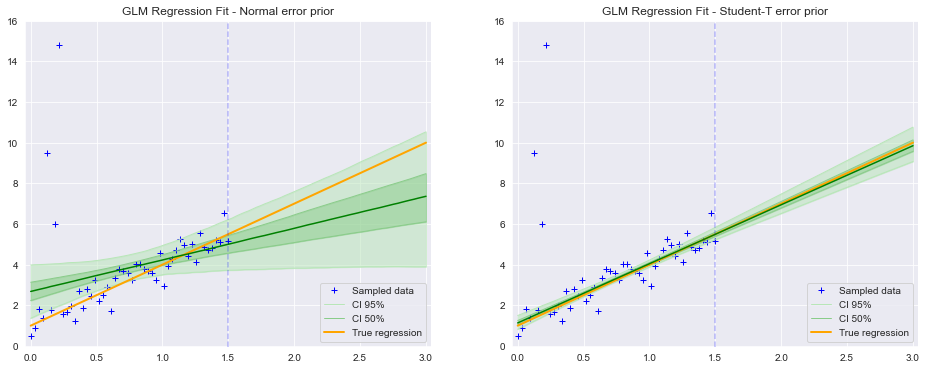

In [13]:
def plot_intervals(ax, y_pred, title, pal, loc, y_min, y_max):
    plt.fill_between(x_predicted,y_pred[0,:],y_pred[4,:],alpha=0.5, color=pal[1])
    plt.fill_between(x_predicted,y_pred[1,:],y_pred[3,:],alpha=0.5, color=pal[2])
    plot_intervals_line(ax, y_pred, title, pal, loc, 1, y_min, y_max)

def plot_intervals_line(ax, y_pred, title, pal, loc, lw, y_min, y_max):
    plot_sample_data(ax, y_min, y_max)
    plt.plot(x_predicted, y_pred[0,:], label='CI 95%', lw=lw, c=pal[1])
    plt.plot(x_predicted, y_pred[4,:], lw=lw, c=pal[1])
    plt.plot(x_predicted, y_pred[1,:], label='CI 50%', lw=lw, c=pal[2])
    plt.plot(x_predicted, y_pred[3,:], lw=lw, c=pal[2])
    plot_true_regression_line(title, loc)

def plot_regression(y_pred_normal, y_pred_student, loc, y_min, y_max):
    fig = plt.figure(figsize=(fig_size_x, fig_size_y))
    ax1 = fig.add_subplot(121)
    plot_intervals(ax1, y_pred_normal, 'GLM Regression Fit - Normal error prior', pal_1, loc, y_min, y_max)
    plt.plot(x_predicted, y_pred_normal[2,:], c=pal_1[5],label='Posterior regression')
    ax2 = fig.add_subplot(122)
    plot_intervals(ax2, y_pred_student, 'GLM Regression Fit - Student-T error prior', pal_1, loc, y_min, y_max)
    plt.plot(x_predicted, y_pred_student[2,:], c=pal_1[5], label='Posterior regression')

y_pred_normal_glm = calculate_regression_line(trace_normal_glm_explicit)
y_pred_studentT_glm = calculate_regression_line(trace_studentT_glm_explicit)

plot_regression(y_pred_normal_glm, y_pred_studentT_glm, 4, y_min_compact, y_max_compact)

Now we can clearly see that for the Student-T model the posterior mean and confidence intervals lie very close to the true regression line. In this case where the data is truly a linear model with outliers, this is a good result. Later in this article we consider a non-parametric model which can follow the linear trend line while also modelling fluctuations in observations, which may convey local information which we might wish to preserve.

## Posterior predictive power
Bayesian inference works my seeking modifications to the parameterized prior probability distributions in order to maximise a likelihood function of the observed data over the prior parameters.

Detailed analysis of the posterior distributions can be obtained by running ***pymc3.plots.traceplot(trace)***.

PyMC3 gives us the method ***pymc3.sampling.sample_posterior_predictive(trace)*** which generates posterior predictive samples based on the conditioned priors. The number of samples to generate can be specified in parameter $samples$ but according to the PyMC3 documentation [10], quote "It is not recommended to modify this value; when modified, some chains may not be represented in the posterior predictive sample."

It is interesting to consider what happens to the expected posterior in regions where we have missing sample data. As we are modelling with a strong linear sampling likelihood, we should find that the posterior predictions follow the regression line, taking into account fluctuations due to the error term.

#### Modelling unobserved data
As mentioned in the setup section above, we have created a ***y_predicted*** array of observations which is based on the true linear model in the range x = 0 to x = 1.5, but  in the region 1.5 to 3 the observations array is masked, indicating that these are ***unobserved*** samples. PyMC3 follows the approach of treating these unobserved samples as additional missing variables, *y_missing* and computes a posterior distribution over the full sample space conditional upon the observed data.

Re-running the models with this extended sample space yields the following summary statistics which now includes the inferred, or imputed, observations. All that has changed here is that we are running with x_predicted, y_predicted instead of x_observed, y_observed. When we run this model we see in the summary not only the priors for $a_0$, $b_0$, $nu_0$ but also the imputed priors for missing data all missing $y_0$.

In [14]:
trace_normal_glm_pred, y_posterior_normal_glm_pred = create_normal_glm_model(samples_glm, tune_glm, x_predicted, y_predicted)
trace_studentT_glm_pred, y_posterior_studentT_glm_pred = create_studentT_glm_model(samples_glm, tune_glm, x_predicted, y_predicted)

pm.summary(trace_studentT_glm_pred)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, sigma_0, b_0, a_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 372.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 3000/3000 [00:02<00:00, 1134.65it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, nu_0, b_0, a_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:49<00:00, 81.29draws/s]
The acceptance probability does not match the target. It is 0.9099125824390621, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 3000/3000 [00:02<00:00, 1478.78it/s]


mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
a_0              2.894   0.175   2.582    3.235      0.005    0.003    1335.0   
b_0              1.151   0.158   0.870    1.455      0.004    0.003    1732.0   
y_0_missing[0]   5.495   1.691   3.623    7.735      0.057    0.049     894.0   
y_0_missing[1]   5.529   2.875   2.520    8.239      0.146    0.125     388.0   
y_0_missing[2]   5.709   1.505   4.247    7.602      0.067    0.060     509.0   
y_0_missing[3]   5.796   1.077   3.842    7.233      0.030    0.027    1320.0   
y_0_missing[4]   5.803   1.935   3.769    8.226      0.048    0.052    1617.0   
y_0_missing[5]   5.949   2.143   2.523    8.550      0.081    0.074     708.0   
y_0_missing[6]   6.071   1.380   4.305    7.518      0.057    0.050     594.0   
y_0_missing[7]   6.156   1.604   4.647    7.892      0.037    0.039    1921.0   
y_0_missing[8]   6.163   1.274   4.304    7.776      0.037    0.026    1209.0   
y_0_missing[9]   6.299   1.081   4.752    8.422      0.026    0.018    1762.0   
y_0_missing[10]  6.458   3.409   4.363    8.903      0.168    0.141     412.0   
y_0_missing[11]  6.363   4.047   2.978    9.479      0.205    0.212     390.0   
y_0_missing[12]  6.373   2.329   4.190    8.351      0.121    0.105     372.0   
y_0_missing[13]  6.663   0.983   5.082    8.439      0.018    0.016    2875.0   
y_0_missing[14]  6.699   2.689   4.834    9.106      0.085    0.107     999.0   
y_0_missing[15]  6.673   2.858   4.720    8.944      0.196    0.138     214.0   
y_0_missing[16]  8.742  10.443   3.802   10.291      1.786    1.274      34.0   
y_0_missing[17]  6.903   2.168   4.481    9.681      0.149    0.105     212.0   
y_0_missing[18]  7.112   1.068   5.535    8.838      0.024    0.018    2026.0   
y_0_missing[19]  7.190   1.269   5.299    9.224      0.031    0.027    1671.0   
y_0_missing[20]  7.535   5.053   5.196    9.774      0.244    0.232     427.0   
y_0_missing[21]  7.535   2.489   5.363    9.513      0.123    0.089     409.0   
y_0_missing[22]  7.503   2.055   5.347    9.881      0.062    0.055    1088.0   
y_0_missing[23]  7.575   1.288   5.664    9.234      0.044    0.039     844.0   
y_0_missing[24]  7.343   3.273   5.153    9.632      0.192    0.136     289.0   
y_0_missing[25]  8.166   5.157   4.908   12.118      0.493    0.482     109.0   
y_0_missing[26]  7.842   1.969   5.700    9.949      0.045    0.039    1893.0   
y_0_missing[27]  7.892   2.186   5.937    9.599      0.063    0.107    1207.0   
y_0_missing[28]  7.914   1.658   5.618   10.090      0.058    0.041     818.0   
y_0_missing[29]  8.047   1.728   5.955   10.302      0.050    0.051    1217.0   
y_0_missing[30]  8.167   1.729   6.355    9.781      0.042    0.049    1671.0   
y_0_missing[31]  8.204   1.886   6.329   10.479      0.048    0.047    1560.0   
y_0_missing[32]  8.429   1.842   5.966   10.055      0.063    0.051     859.0   
y_0_missing[33]  8.374   3.728   6.291   10.706      0.199    0.157     351.0   
y_0_missing[34]  8.571   1.963   5.635   11.301      0.050    0.090    1513.0   
y_0_missing[35]  8.634   1.447   6.628   10.896      0.047    0.033     950.0   
y_0_missing[36]  8.656   0.980   6.818   10.330      0.022    0.015    2073.0   
y_0_missing[37]  8.786   1.155   6.876   10.633      0.032    0.026    1293.0   
y_0_missing[38]  8.768   3.353   7.078   11.055      0.143    0.112     547.0   
y_0_missing[39]  8.936   1.100   7.235   10.498      0.028    0.020    1572.0   
y_0_missing[40]  9.029   3.698   6.978   10.962      0.200    0.177     341.0   
y_0_missing[41]  9.153   1.393   6.949   11.116      0.033    0.028    1738.0   
y_0_missing[42]  8.917   4.355   7.105   11.120      0.250    0.229     303.0   
y_0_missing[43]  9.313   1.335   7.494   11.740      0.030    0.024    2040.0   
y_0_missing[44]  8.955   8.447   7.022   11.336      0.482    0.384     307.0   
y_0_missing[45]  9.499   1.245   7.611   11.482      0.025    0.022    2551.0   
y_0_missing[46]  9.953   4.866   7.198   12.169  

#### Plotting predictive samples
Having inferred the full range of predicted sample observations we can plot these, along with credibility intervals as before, and see that the inferred observations have been well fitted to the expected linear model, complying with the constraint that we are modelling intercept and slope as our sampling distribution and hence expect to get a linear set of expected observations:

Text(0.5, 0.98, 'Predicting from Linear Model')

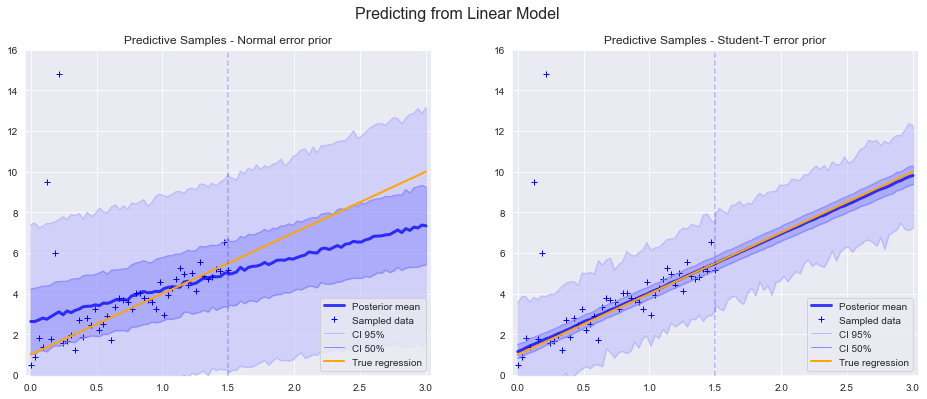

In [15]:
def plot_actuals(y_posterior_normal, y_posterior_student, loc, y_min, y_max):
    y_pred_normal = np.percentile(y_posterior_normal, quartiles, axis=0)
    y_pred_studentT = np.percentile(y_posterior_student, quartiles, axis=0)
    fig = plt.figure(figsize=(fig_size_x, fig_size_y))
    ax1 = fig.add_subplot(121)
    plt.plot(x_predicted, y_pred_normal[2,:],alpha=0.75, lw=3, color=pal_2[5],label='Posterior mean')
    plot_intervals(ax1, y_pred_normal, 'Predictive Samples - Normal error prior', pal_2, loc, y_min, y_max)
    ax2 = fig.add_subplot(122)
    plt.plot(x_predicted, y_pred_studentT[2,:],alpha=0.75, lw=3, color=pal_2[5],label='Posterior mean')
    plot_intervals(ax2, y_pred_studentT, 'Predictive Samples - Student-T error prior', pal_2, loc, y_min, y_max)
    return fig

fig = plot_actuals(y_posterior_normal_glm_pred, y_posterior_studentT_glm_pred, 4, y_min_compact, y_max_compact)
fig.suptitle('Predicting from Linear Model', fontsize=16)

## Non-parametric Inference Models
Having verified the linear model, it would be interesting to see if we can model these sample observations with a non-parametric model, where we dispense with finding intercept and slope parameters and instead try to model the observed data directly with priors on every datapoint across the sample space [11].

### Non-Stationary data and Random Walk prior [12]
The simple assumption with a non-parametric model is that the data is stationary, so the observed samples at each datapoint do not trend in a systematic way across contiguous regions. Real-world data does in fact very often trend, or is at least constrained by requirements of smoothness to adjacent data points, for example in flow dynamics, geographical or time series data. This brings in factors relating to the ordering, continuity, closeness and smoothness of data points, typically represented in Gaussian Processes using kernel functions.

The choice of priors is crucial [13]. In our scenario we are anticipating that the data is non-stationary, since it has a clear trend over x. If we use a simple gaussian prior for our observations, even after conditioning with the observed data, as soon as we enter the unobserved region, the predicted observations rapidly return to their prior mean as below:

### Stationary mean prior

In [16]:
def create_normal_stationary_inference_model(samples, tune, y):
    with pm.Model() as model_normal:
        sigma_0 = pm.HalfCauchy('sigma_0', beta=10)
        sigma_1 = pm.HalfCauchy('sigma_1', beta=10)
        mu_0 = pm.Normal('mu_0', mu=0, sd=sigma_1, shape=y.size)
        y_0 = pm.Normal('y_0', mu=mu_0, sd=sigma_0, observed=y)
        trace = pm.sample(samples, tune=tune, random_seed=123, cores=2, chains=2)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123)['y_0']

def create_studentT_stationary_inference_model(samples, tune, y):
    with pm.Model() as model_studentT:
        nu_0 = pm.Gamma('nu_0', alpha=2, beta=0.1)
        sigma_1 = pm.HalfCauchy('sigma_1', beta=10)
        mu_0 = pm.Normal('mu_0', mu=0, sd=sigma_1, shape=y.size)
        y_0 = pm.StudentT('y_0', mu=mu_0, lam=8.368, nu=nu_0, observed=y)
        trace =  pm.sample(samples, tune=tune, random_seed=123, cores=2, chains=2)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123)['y_0']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, mu_0, sigma_1, sigma_0]
Sampling 2 chains, 143 divergences: 100%|██████████| 7000/7000 [00:18<00:00, 384.70draws/s]
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5647291636598322, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 4000/4000 [00:02<00:00, 1433.51it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, mu_0, sigma_1, nu_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [01:11<00:00, 98.24draws/s]
The number of 

Text(0.5, 0.98, 'Predicting from stationary mean prior')

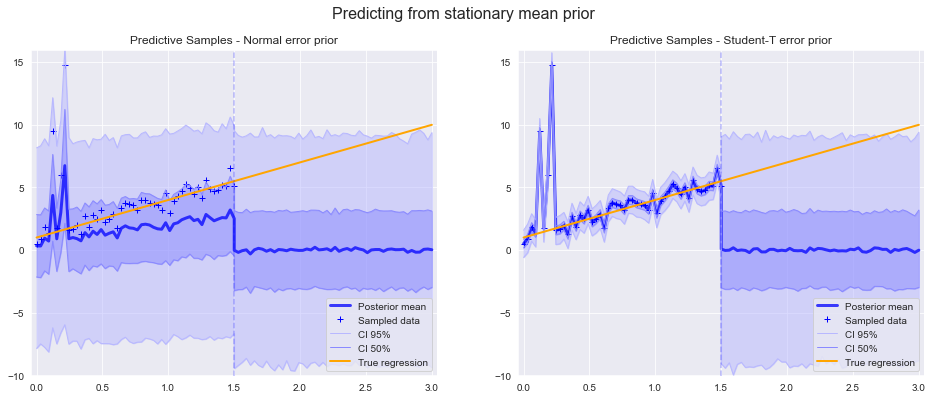

In [17]:
trace_normal, y_posterior_normal = create_normal_stationary_inference_model(samples_predictive, tune_predictive, y_predicted)
trace_studentT, y_posterior_studentT = create_studentT_stationary_inference_model(samples_predictive, tune_predictive, y_predicted)

fig = plot_actuals(y_posterior_normal, y_posterior_studentT, 4, y_min_spread, y_max_compact)
fig.suptitle('Predicting from stationary mean prior', fontsize=16)

### Gaussian Random Walk prior
The Gaussian random walk prior gives us the ability to model a non-stationary data set because it estimates an observable based on the previous data point value plus a random walk step. The PyMC3 implementation also allows us to model a drift parameter which adds a fixed scalar to each random walk step. In the following inference model we have used a single scalar drift parameter which in this scenario is equivalent to a slope on the data in the direction of the drift. We could potentially allow the drift parameter to be conditioned on each observable separately which would allow flexibility in the line shape but that is beyond our current scope. As it turns out we are able to get a very good fit to the true regression line using this scalar drift model. 

It is important that data, including outliers, is correctly ordered with equal sample step size as the prior will assume this consistency in modelling the data. For this reason our outliers are inserted into the x array at index points rather than appended as (x, y) pairs as in the original scenario [1].

In [18]:
def create_normal_grw_inference_model(samples, tune, y, drift):
    with pm.Model() as model_normal:
        sigma_0 = pm.HalfCauchy('sigma_0', beta=10)
        sigma_1 = pm.HalfCauchy('sigma_1', beta=10)
        if drift:
            mu_drift = pm.Normal('mu_drift', mu=1, sigma=2)
            mu_0 = pm.GaussianRandomWalk('mu_0', mu=mu_drift, sd=sigma_1, shape=y.size)
        else:
            mu_0 = pm.GaussianRandomWalk('mu_0', mu=0, sd=sigma_1, shape=y.size)
        y_0 = pm.Normal('y_0', mu=mu_0, sd=sigma_0, observed=y)
        trace = pm.sample(samples, tune=tune, random_seed=123, cores=2, chains=2)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123)['y_0']

def create_studentT_grw_inference_model(samples, tune, y, drift):
    with pm.Model() as model_studentT:
        nu_0 = pm.Gamma('nu_0', alpha=2, beta=0.1)
        sigma_1 = pm.HalfCauchy('sigma_1', beta=10)
        if drift:
            mu_drift = pm.Normal('mu_drift', mu=1, sigma=2)
            mu_0 = pm.GaussianRandomWalk('mu_0', mu=mu_drift, sd=sigma_1, shape=y.size)
        else:
            mu_0 = pm.GaussianRandomWalk('mu_0', mu=0, sd=sigma_1, shape=y.size)
        y_0 = pm.StudentT('y_0', mu=mu_0, lam=8.368, nu=nu_0, observed=y)
        trace =  pm.sample(samples, tune=tune, random_seed=123, cores=2, chains=2)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123)['y_0']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, mu_0, sigma_1, sigma_0]
Sampling 2 chains, 1 divergences: 100%|██████████| 7000/7000 [00:55<00:00, 126.00draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.564156886386975, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 4000/4000 [00:02<00:00, 1414.29it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, mu_0, sigma_1, nu_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [02:39<00:00, 44.00draws/s]
The acceptance probability does not match the target. It is 0.9516086171826205, but should be close to 0.8. Try to increase the n

Text(0.5, 0.98, 'Predicting from Gaussian Random Walk prior with Drift')

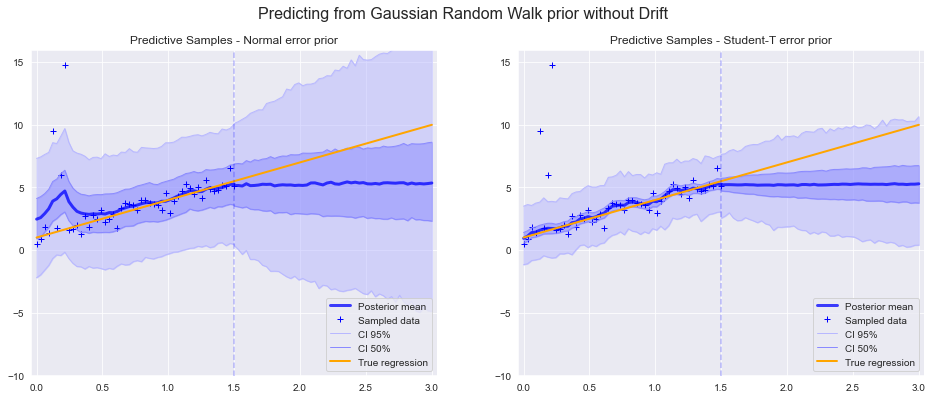

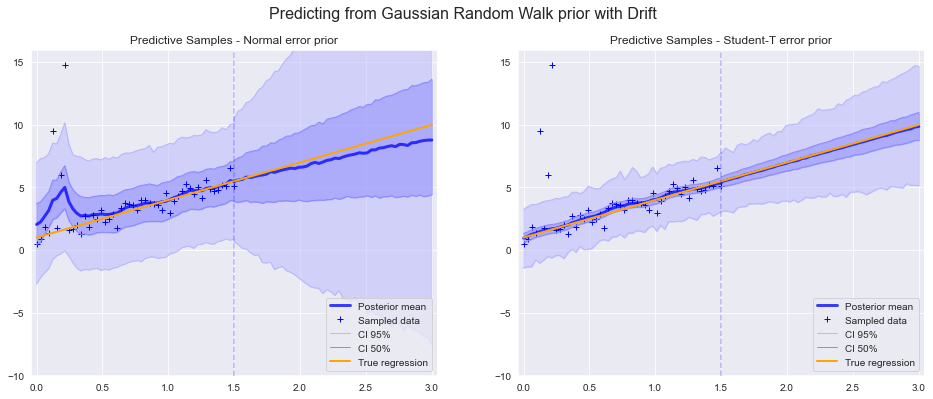

In [19]:
trace_normal, y_posterior_normal = create_normal_grw_inference_model(samples_predictive, tune_predictive, y_predicted, False) # Without Drift
trace_studentT, y_posterior_studentT = create_studentT_grw_inference_model(samples_predictive, tune_predictive, y_predicted, False) # Without Drift

fig = plot_actuals(y_posterior_normal, y_posterior_studentT, 4, y_min_spread, y_max_compact)
fig.suptitle('Predicting from Gaussian Random Walk prior without Drift', fontsize=16)

trace_normal, y_posterior_normal = create_normal_grw_inference_model(samples_predictive, tune_predictive, y_predicted, True) # With Drift
trace_studentT, y_posterior_studentT = create_studentT_grw_inference_model(samples_predictive, tune_predictive, y_predicted, True) # With Drift

fig = plot_actuals(y_posterior_normal, y_posterior_studentT, 4, y_min_spread, y_max_compact)
fig.suptitle('Predicting from Gaussian Random Walk prior with Drift', fontsize=16)

### Inference Model Credible Intervals
The resulting Posterior mean and credible intervals for our inference model are remarkably smooth as a result of our sampling and give at least as good a fit as the glm Model. We now have the benefit that we can see the effect of the outliers, which in the case of the Normal error case affects the initial inferred values, and skews the overall drift parameter, but the Student-T prior has been able to accommodate this perturbation and converge to the true regression line.

## Plotting Posterior Samples of Gaussian Random Walk model
PyMC3 has a nice method for plotting the predictive posteriors for the glm model but we have to do a little bit of work to get the same result in this case. The following code samples the predicted posteriors and plots them individually.

In [20]:
def plot_samples(y_posterior, samples):
    show_label = True
    for rand_loc in np.random.randint(0, len(y_posterior), samples):
        rand_sample = y_posterior[rand_loc]
        if show_label:
            plt.plot(x_predicted, rand_sample, alpha=0.05, c=pal_1[5], label='Posterior samples')
            show_label = False
        else:
            plt.plot(x_predicted, rand_sample, alpha=0.05, c=pal_1[5])

def plot_posterior_predictive(y_posterior_normal, y_posterior_student, loc, samples, y_min, y_max):
    y_pred_normal = np.percentile(y_posterior_normal, quartiles, axis=0)
    y_pred_studentT = np.percentile(y_posterior_student, quartiles, axis=0)
    fig = plt.figure(figsize=(fig_size_x, fig_size_y))
    ax1 = fig.add_subplot(121)
    plot_samples(y_posterior_normal, samples)
    plt.plot(x_predicted, y_pred_normal[2,:], alpha=0.75, lw=3, color=pal_2[5], label='Posterior mean')
    plot_intervals_line(ax1, y_pred_normal, 'Random Walk Prior: Predictive Samples - Normal error prior', pal_2, loc, 2, y_min, y_max)
    ax2 = fig.add_subplot(122)
    plot_samples(y_posterior_student, samples)
    plt.plot(x_predicted, y_pred_studentT[2,:], alpha=0.75, lw=3, color=pal_2[5], label='Posterior mean')
    plot_intervals_line(ax2, y_pred_studentT, 'Random Walk Prior: Predictive Samples - Student-T error prior', pal_2, loc, 2, y_min, y_max)

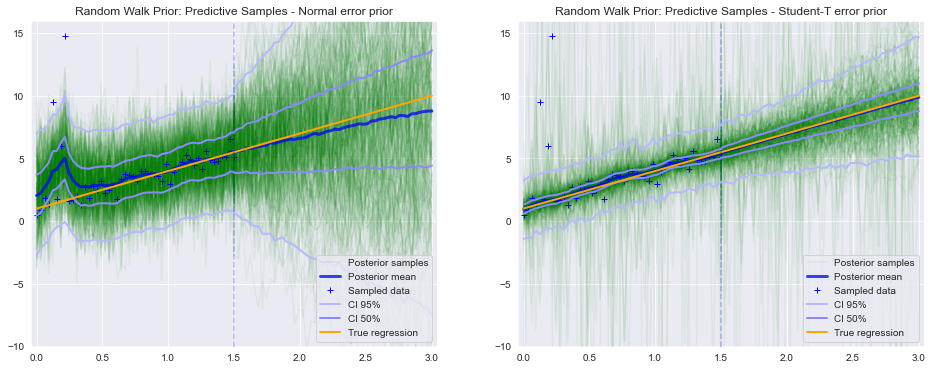

In [21]:
plot_posterior_predictive(y_posterior_normal, y_posterior_studentT, 4, 250, y_min_spread, y_max_compact)

As can be seen Gaussian random walk is highly chaotic and can diverge rapidly away from the observed data. We should not expect any particular path to be close to the actual predicted path of our sample data. In this sense it is a truly stochastic method as our result is derived purely from the statistical mean of the sampled paths, not from any particular path.


It is interesting to take a look at the prior distributions for any anomalies. In this case there are quite a few divergences and the inferred observables y_0_missing have very large extremities, but the drift and random walk mean are as expected and the observation degrees of freedom parameter $nu_0$ converges nicely.
![Bayesian Inference](http://www.appliedmachinelearning.ai/assets/images/priors_trace.jpg "Priors trace for Gaussian Random Walk")

In [22]:
#pm.traceplot(trace_studentT)

## Impact of Outliers on Random Walk predictive posteriors
Having seen the effect that the outliers have on the posterior mean, we could surmise that the great noisiness of the predictive samples might be due to perturbation of the random walk search space caused by the outliers.

To test this, as a final test we have here removed the outliers and rerun the same predictive modes.

In [23]:
# Remove the outliers
y = true_intercept + true_slope * x_observed + np.random.default_rng(seed=123).normal(scale=0.5, size=observables) # Add noise

y_observed, y_predicted = add_outliers(y, [], [])

trace_normal, y_posterior_normal_linear = create_normal_grw_inference_model(samples_predictive, tune_predictive, y_predicted, True) # With Drift
trace_studentT, y_posterior_studentT_linear = create_studentT_grw_inference_model(samples_predictive, tune_predictive, y_predicted, True) # With Drift

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_0_missing, mu_0, mu_drift, sigma_1, sigma_0]
Sampling 2 chains, 81 divergences: 100%|██████████| 7000/7000 [05:43<00:00, 20.37draws/s]
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5897923930741469, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9915788611704943, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 4000/4000 [00:02<00:00, 1439.00it/s]
Auto-assigning 

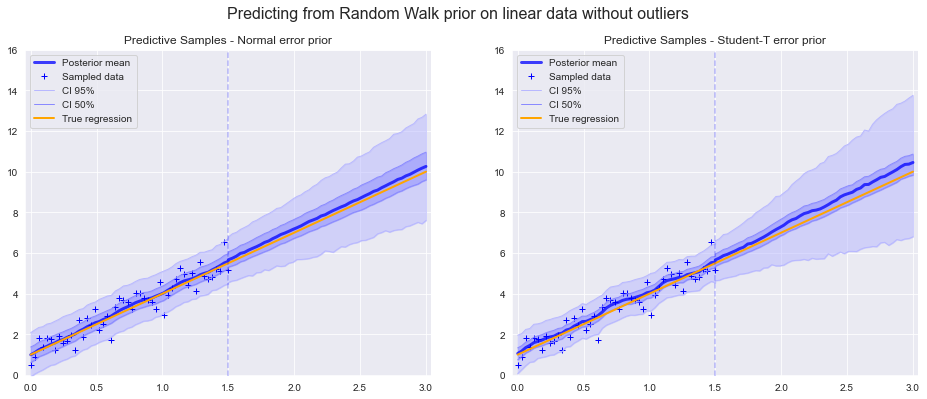

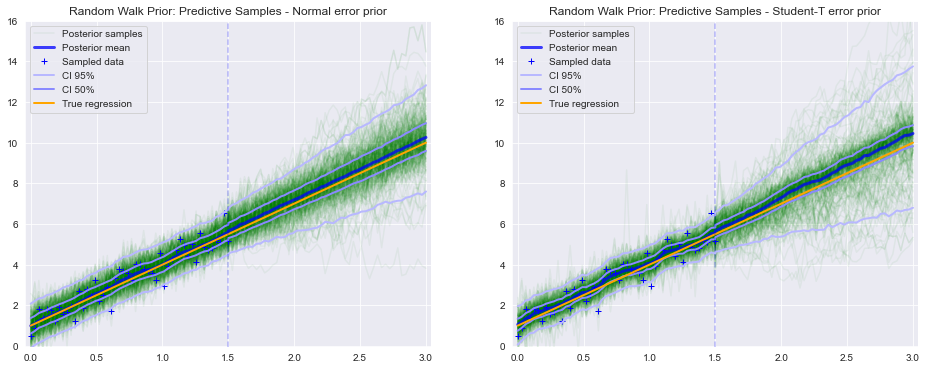

In [24]:
fig = plot_actuals(y_posterior_normal_linear, y_posterior_studentT_linear, 2, y_min_compact, y_max_compact)
fig.suptitle('Predicting from Random Walk prior on linear data without outliers', fontsize=16)
plot_posterior_predictive(y_posterior_normal_linear, y_posterior_studentT_linear, 2, 250, y_min_compact, y_max_compact)

As can be seen, the predictive samples are much cleaner, with very tight credibility intervals and much smaller divergence of the random walk samples. This gives us confidence that with a correct model the Gaussian random walk is a well conditioned prior for non-stationary model fitting.

## Conclusion
The intention of this article was to show the simplicity and power of Bayesian learning with PyMC3.

1. We have reproduced the results of Thomas Wiecki that the Student-T error prior performs better that the Normal prior in robust linear regression
2. We have demonstrated that refining the degrees of freedom on the Student-T error prior does indeed improve the fit to the regression line
3. We have shown we can quickly and easily draw credibility intervals on the posterior samples for both the linear regression and the non-parametric models
4. We have demonstrated that the non-parametric model using Gaussian random walk can project very well the linear model into unobserved regions and at the same time allow model local fluctuations in the observed data which we might want to preserve
5. We have investigated the Gaussian random walk prior and shown that its chaotic behaviour allows it to explore a wide sample space while not preventing it generating smooth predictive posterior means

It would be interesting to explore regularization techniques and more complex data to see how far we can take these relatively simple non-parametric models using PyMC3

## References
1. T. Wiecki, [GLM: Robust Linear Regression](https://docs.pymc.io/notebooks/GLM-robust.html) (2018), PyMC3
2. J. Salvatier1, T. Wiecki, C. Fonnesbeck, [Probabilistic programming in Python using PyMC3](https://pdfs.semanticscholar.org/8085/b60ce1771647f11ccc4728397275b502f359.pdf) (2016), PeerJ Computer Science
3. J. Salvatier1, C. Fonnesbeck, T. Wiecki, [GLM: Robust Regression with Outlier Detection](https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GLM-robust-with-outlier-detection.html) (2016), PyMC3
4. M. Waskom, [seaborn.regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) (2012-2020), seaborn.pydata
5. J. Jones, M. Mastanduno, T. Larsen, [Machine Learning Versus Statistics: When to use each - healtcare.ai](https://healthcare.ai/machine-learning-versus-statistics-use/ (), healthcare.ai
6. Darrin, [Linear Regression vs Bayesian Regression](https://educationalresearchtechniques.com/2017/10/18/linear-regression-vs-bayesian-regression/) (2017), Educational Research Techniques
7. PyMC3 Development team, [Continuous Distributions](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.StudentT) (2018), PyMC3 API
8. A. Gelman, [Best practice for Student-T prior](https://statmodeling.stat.columbia.edu/2015/05/17/) (2015), Statistical Modeling, Causal Inference
9. [Bayesian Credible Interval](https://en.wikipedia.org/wiki/Credible_interval) (2020), Wikipedia
10. PyMC3 Development team, [Inference Sampling](https://docs.pymc.io/api/inference.html) (2018), PyMC3 API
11. P. Orbanz, Y. W. Teh, [Bayesian Nonparametric Models](https://www.stats.ox.ac.uk/~teh/research/npbayes/OrbTeh2010a.pdf) (2010), University of Oxford, Department of Statistics
12. T. Iordanova, [An Introduction to Stationary and Non-Stationary Processes](https://www.investopedia.com/articles/trading/07/stationary.asp) (2020), Investopedia
13. A. Gelman, [Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) (2020), stan-dev/stan
14. Hiro, [Bayesian Regression using PyMC3](https://h1ros.github.io/posts/bayesian-regression-using-pymc3/) (2019)
15. Paul, [PYMC3 Bayesian Prediction Cones](https://stackoverflow.com/questions/45828517/pymc3-bayesian-prediction-cones) (2017) stack overflow